# Home task 

1) Replicate Simple recommender implementation 
2) (optional) Replicate the the content based  recommender implementation 
3) Find the public dataset and apply collaborative filtering recommendation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Functions for future use:

## Collaborative Filtering Cost Function

$$ J =\frac{1}{2}\sum{((X @ \Theta-Y)*R)^2} + \frac{\lambda}{2}\sum{X^2} + \frac{\lambda}{2}\sum{\Theta^2}$$

In [2]:
def J(Y, R, X, Theta, lambd):
    assert (X.shape[1] == Theta.shape[0])
    h = X @ Theta

    try:
        assert (h.shape == Y.shape)
    except:
        print('h.shape {} !=Y.shape {}'.format(h.shape, Y.shape))

    J = 1/2 * np.sum(((h-Y)*R) ** 2) + lambd/2 * \
        np.sum(X**2) + lambd/2 * np.sum(Theta**2)

    try:
        assert (len(J.shape) == 0)
    except:
        print('J is not raw number. J.shape = ', J.shape)

    return J

## Collaborative Filtering Cost Function Gradient
 
$$\frac{\partial J}{\partial X}=((X @ \Theta-Y)*R) @ \Theta^{T}+ \lambda X, \quad
\frac{\partial J}{\partial \theta}= \left( ((X @ \Theta-Y)*R)^{T} @ X \right)^{T} + \lambda  \Theta $$

In [3]:
def J_derivative(Y, R, X, Theta, lambd):

    cost_matr = (X @ Theta - Y) * R

    X_grad = cost_matr @ Theta.T
    Theta_grad = (cost_matr.T @ X).T

    try:
        assert (X_grad.shape == X.shape)
        assert (Theta_grad.shape == Theta.shape)
    except:
        print('Check gradient calculus')

    X_grad += lambd * X
    Theta_grad += lambd * Theta

    return X_grad, Theta_grad

## Gradient descent (`fit`)

In [4]:
def fit(Y, R, num_features=10,  alpha=0.0001, lambd=.01, eps=.1,  max_iter=1000, step=100, verbose=0):
    num_movies, num_users = Y.shape

    if verbose:
        print('Running gradient descent with alpha= {}, lambda= {}, eps= {}, max_iter= {}'.format(
            alpha, lambd, eps, max_iter))

    np.random.seed(2019)
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn(num_features, num_users)

    J_hist = [-1]
    continue_iter = True
    iter_number = 0

    while continue_iter:

        X_grad, Theta_grad = J_derivative(
            Y, R, X, Theta, lambd)
        X = X - alpha * X_grad
        Theta = Theta - alpha * Theta_grad

        J_hist.append(J(Y, R, X, Theta, lambd))

        if iter_number > max_iter:
            continue_iter = False
            print('iter_number> max_iter')

        elif np.abs(J_hist[iter_number-1] - J_hist[iter_number]) < eps:
            continue_iter = False
            print('J_hist[iter_number]={}'.format(J_hist[iter_number]))
        iter_number += 1

        if verbose and iter_number % step == 0:
            print('{}: {}'.format(iter_number, J_hist[iter_number-1]))

    return X, Theta, J_hist

### Getting a dataset

In [5]:
def Get_Data():
    Dataset = pd.read_csv(
        "E:/Camp all task/Task_17.(cofi)/Dataset/ratings_small.csv")

    # Remove an unnecessary column from the data for convenience!
    Dataset = Dataset.drop('timestamp', axis=1)

    return Dataset

### converting data into a matrix

In [6]:
def Convert_to_Matrix(Dataset, value, index, columns):
    Dataset_target = Dataset.pivot_table(value, index, columns, aggfunc=np.max, dropna=False)
    Dataset_target = Dataset_target.fillna(0)
    return Dataset_target

### Obtaining Y and R

In [7]:
def get_Y_and_R(Matrix):
    
    # I use 'copy()' to avoid assigning a reference to the value itself and avoid further problems
    Y = Matrix.fillna(0)
    R = Matrix.fillna(0)
    R[R > 0] = 1
    
    return Y, R

### Data visualization

In [8]:
def draw_cost_changes(J_hist):
    J_hist = J_hist[1:]
    plt.figure()
    plt.scatter(np.arange(0, len(J_hist)), J_hist, s=20, marker='.', c='b')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')

### Normalization

In [9]:
def normalize_Y(Y, R, num_movies):
    Ymean = np.zeros((num_movies, 1))
    Ynorm = np.zeros(Y.shape)

    for i in range(num_movies):
        idx = R[i, :] == 1
        Ymean[i] = Y[i, idx].mean()
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ymean, Ynorm

### Getting Y_scaled

In [10]:
def get_Y_scaled(Y):
    scale = Y.max() - Y.min()
    Y_scaled = Y / scale * 10
    return Y_scaled, scale

# Simple recommender implementation:

In [11]:
Df = Get_Data()
Df

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


### I convert the data into a matrix to create the desired view:

<img src= 'problem_formulation1.png' width= '600' align='left'>
<img src= 'stars.png' width= '150' align='left'>

In [12]:
Df = Convert_to_Matrix(Df, value='rating', index='movieId', columns='userId')
Df

C:\Users\38098\AppData\Local\Temp\ipykernel_6168\3295130093.py:2: FutureWarning: The provided callable <function max at 0x000001BFB2B2F240> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  Dataset_target = Dataset.pivot_table(value, index, columns, aggfunc=np.max, dropna=False)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Let's get Y and R

In [13]:
Y, R = get_Y_and_R(Df)

print('Y.shape=', Y.values.shape)
print('Y[:5] =\n', Y.values[:5])
print('\nUnique values of Y:\n', set(Y.values.ravel()))

Y.shape= (9066, 671)
Y[:5] =
 [[0. 0. 0. ... 0. 4. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unique values of Y:
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 3.5, 2.5, 4.5, 1.5, 0.5}


In [14]:
print('R.shape=', R.values.shape)
print('R[:5] =\n', R.values[:5])
print('\nUnique values of R:\n', set(R.values.ravel()))

R.shape= (9066, 671)
R[:5] =
 [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unique values of R:
 {0.0, 1.0}


In [15]:
X, Theta,J_hist = fit(Y.values,R.values,alpha=0.001, lambd= 1,max_iter= 3000, verbose=1)

Running gradient descent with alpha= 0.001, lambda= 1, eps= 0.1, max_iter= 3000
100: 133380.63852158212
200: 105574.75354014961
300: 87610.27019068823
400: 74296.06951497961
500: 64138.14478196732
600: 56427.23582590831
700: 50667.676769254256
800: 46425.811410951355
900: 43313.80505212854
1000: 41002.67239510212
1100: 39237.15217202058
1200: 37844.07154297936
1300: 36718.4580740978
1400: 35795.94395861009
1500: 35032.69234908024
1600: 34396.38934091808
1700: 33862.47956614897
1800: 33411.94556081852
1900: 33029.73725153646
2000: 32703.745828585586
2100: 32424.162112184273
2200: 32183.033643643517
2300: 31973.910887615588
2400: 31791.54837363179
2500: 31631.65978794511
2600: 31490.72659560736
2700: 31365.851503470036
2800: 31254.644491281906
2900: 31155.13107841718
3000: 31065.67633989449
iter_number> max_iter


## Visualize cost function history 

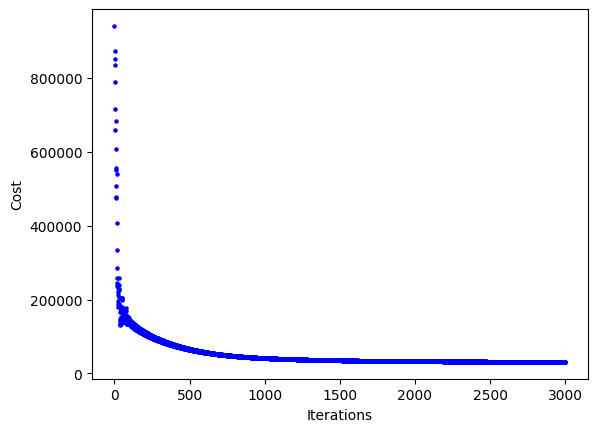

In [16]:
draw_cost_changes(J_hist)

## Predict missed values of training data 

In [17]:
pred = X @ Theta
pred

array([[ 2.50806780e+00,  3.08244400e+00,  3.28709453e+00, ...,
         4.00017198e+00,  3.72934650e+00,  4.26403631e+00],
       [ 2.10134246e+00,  3.59375863e+00,  3.50071172e+00, ...,
         3.31763098e+00,  3.73328047e+00,  3.41185743e+00],
       [ 1.80200906e+00,  2.69621909e+00,  3.08443966e+00, ...,
         2.35396973e+00,  3.67960182e+00,  2.12975814e+00],
       ...,
       [ 9.72386003e-01,  4.78805625e-01,  2.71234917e+00, ...,
         1.58344590e+00,  1.05881805e+00,  2.10886104e+00],
       [ 5.17723362e-01, -4.03913954e-03,  1.45695572e+00, ...,
         7.72237803e-01,  1.88515217e-01,  1.19110337e+00],
       [ 6.80208584e-01,  3.33839664e-02, -3.27173739e-01, ...,
         2.86102583e-01, -1.74998285e-02,  1.30406887e-01]])

## Evaluate the prediction

Evaluate on provided ratings 

In [18]:
diff_train = (pred - Y.values) * R.values

diff_train_proivided = diff_train.ravel()[np.where(diff_train.ravel() != 0)]
print('Training:', np.abs(diff_train_proivided).max(),np.abs(diff_train_proivided).mean())

Training: 6.067676987272552 0.4741705971439126


(array([9.0000e+00, 5.1000e+01, 1.3600e+02, 4.2400e+02, 2.5830e+03,
        2.8073e+04, 5.9189e+04, 8.6620e+03, 8.1200e+02, 6.5000e+01]),
 array([-6.06767699, -5.12314652, -4.17861604, -3.23408557, -2.2895551 ,
        -1.34502463, -0.40049416,  0.54403631,  1.48856679,  2.43309726,
         3.37762773]),
 <BarContainer object of 10 artists>)

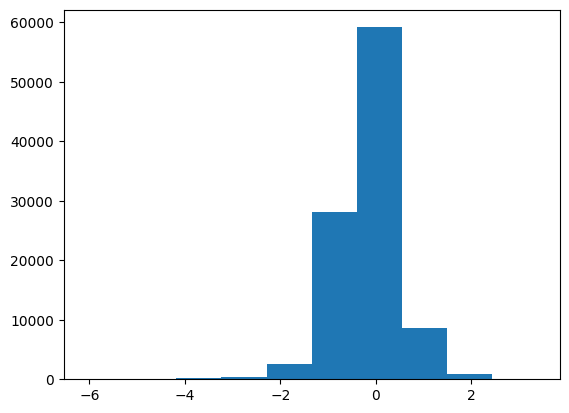

In [19]:
plt.hist(diff_train_proivided.ravel())

## Read movies names 

In [20]:
def Get_movier_name():
    Name_movies = pd.read_csv("E:/Camp all task/Task_17.(cofi)/Dataset/movies_metadata.csv")

    Name_movies = Name_movies.set_index('id')
    
    return Name_movies

In [21]:
Name_movies = Get_movier_name()
Name_movies

,original_title
id,
862,Toy Story
8844,Jumanji
15602,Grumpier Old Men
31357,Waiting to Exhale
11862,Father of the Bride Part II
...,...
439050,رگ خواب
111109,Siglo ng Pagluluwal
67758,Betrayal


## Enter ratings for a new user

In [22]:
def build_raitings():
    New_user_ratings = np.zeros((9066, 1))

    New_user_ratings[0] = 5
    New_user_ratings[97] = 1
    New_user_ratings[6] = 4
    New_user_ratings[11] = 5
    New_user_ratings[53] = 2
    New_user_ratings[63] = 4
    New_user_ratings[65] = 1
    New_user_ratings[68] = 4
    New_user_ratings[182] = 4
    New_user_ratings[225] = 4
    New_user_ratings[354] = 1
    
    return New_user_ratings

In [23]:
New_user_ratings = build_raitings()

print('\n\nNew user ratings:\n')
for i in range(len(New_user_ratings)):
    if New_user_ratings[i] > 0:
        print('Rated {} for {}\n'.format(
            int(New_user_ratings[i][0]), Name_movies.iloc[i].values[0]))



New user ratings:

Rated 5 for Toy Story

Rated 4 for Sabrina

Rated 5 for Dracula: Dead and Loving It

Rated 2 for The Big Green

Rated 4 for Two If by Sea

Rated 1 for Lawnmower Man 2: Beyond Cyberspace

Rated 4 for Friday

Rated 1 for Heidi Fleiss: Hollywood Madam

Rated 4 for The Net

Rated 4 for Death and the Maiden

Rated 1 for I Like It Like That



In [24]:
Y.shape

(9066, 671)

## Add new user ratings to the data matrix


In [25]:
def add_ratings(Y, R, my_ratings):
    Y = np.c_[my_ratings, Y]
    R = np.c_[my_ratings != 0, R]
    return Y, R

In [26]:
New_user_ratings = build_raitings()
Y,R = add_ratings(Y,R,New_user_ratings)

Y.shape,  R.shape

((9066, 672), (9066, 672))

Running gradient descent with alpha= 0.001, lambda= 1, eps= 0.1, max_iter= 3000


100: 110901.23817608079
200: 108778.93796177937
300: 87227.69049514594
400: 73362.91386257904
500: 63539.64200627657
600: 56346.04988499031
700: 50967.02109882391
800: 46900.546697106045
900: 43809.58975969387
1000: 41443.37962026006
1100: 39608.86490807924
1200: 38163.86804600996
1300: 37009.39002586872
1400: 36077.225058394186
1500: 35318.246119238494
1600: 34695.119277195234
1700: 34178.80259639495
1800: 33746.77073390056
1900: 33381.743328885925
2000: 33070.55484271354
2100: 32803.14266704297
2200: 32571.715732962137
2300: 32370.13972646263
2400: 32193.511357772386
2500: 32037.862743729656
2600: 31899.947257836568
2700: 31777.080474711616
2800: 31667.022865679883
2900: 31567.894191397747
3000: 31478.110336402024
iter_number> max_iter


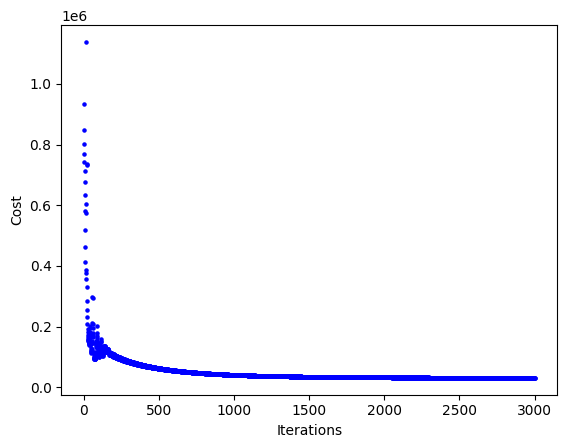

In [27]:
X, Theta, J_hist = fit(Y, R, alpha=0.001, lambd=1,
                       max_iter=3000, eps=.1, step=100, verbose=1)

draw_cost_changes(J_hist)

## Predict 

Recommend for new user 

In [28]:
pred = X @ Theta
my_pred = pred[:,0]

print(my_pred.shape)

top_pred = np.argsort(my_pred)[::-1]
print('\nTop recommendations for you:\n')

for i in range(100):
    j = top_pred[i]
    print('Predicting rating {:.2} for movie {} (# {})\n'.format(
        my_pred[j], Name_movies.iloc[j], j))

(9066,)

Top recommendations for you:

Predicting rating 7.0 for movie original_title    活着
Name: 31439, dtype: object (# 321)

Predicting rating 5.4 for movie original_title    Meet John Doe
Name: 32574, dtype: object (# 946)

Predicting rating 5.4 for movie original_title    Natural Born Killers
Name: 241, dtype: object (# 284)

Predicting rating 5.3 for movie original_title    Love Affair
Name: 43742, dtype: object (# 266)

Predicting rating 5.0 for movie original_title    So Dear to My Heart
Name: 29682, dtype: object (# 997)

Predicting rating 5.0 for movie original_title    Black Tar Heroin: The Dark End of the Street
Name: 79515, dtype: object (# 3185)

Predicting rating 4.9 for movie original_title    French Kiss
Name: 397, dtype: object (# 232)

Predicting rating 4.9 for movie original_title    All Dogs Go to Heaven 2
Name: 19042, dtype: object (# 622)

Predicting rating 4.8 for movie original_title    The Ghost and Mrs. Muir
Name: 22292, dtype: object (# 916)

Predicting rati

# Collaborative filtering:

### Represent each user and each movie as vectors 

<img src= 'cofi_1.png' width= '800' align='left'>	

In [29]:
Df = Get_Data()
Df

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


### Convert input data to matrix

In [30]:
Df_target = Convert_to_Matrix(Df, 'rating', 'movieId', 'userId')
Df_target

C:\Users\38098\AppData\Local\Temp\ipykernel_6168\3295130093.py:2: FutureWarning: The provided callable <function max at 0x000001BFB2B2F240> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  Dataset_target = Dataset.pivot_table(value, index, columns, aggfunc=np.max, dropna=False)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparee `Y` and `R` 

In [31]:
Y, R = get_Y_and_R(Df_target)

print('Y.shape=', Y.values.shape)
print('Y[:5] =\n', Y.values[:5])
print('\nUnique values of Y:\n', set(Y.values.ravel()))

Y.shape= (9066, 671)
Y[:5] =
 [[0. 0. 0. ... 0. 4. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unique values of Y:
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 3.5, 2.5, 4.5, 1.5, 0.5}


In [32]:
print('R.shape=', R.values.shape)
print('R[:5] =\n', R.values[:5])
print('\nUnique values of R:\n', set(R.values.ravel()))

R.shape= (9066, 671)
R[:5] =
 [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unique values of R:
 {0.0, 1.0}


In [33]:
Y_scaled, scale = get_Y_scaled(Y)
Y_scaled

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,...,0.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalization

In [34]:
Ymean,Ynorm = normalize_Y(Y_scaled.values, R.values, Y_scaled.shape[0])

# This array is used to store the average rating value for each movie.
Ymean

array([[ 7.76293297],
       [ 6.82476636],
       [ 6.3220339 ],
       ...,
       [10.        ],
       [ 6.        ],
       [10.        ]])

In [35]:
# The Ynorm array is created with the same size as Y to store the normalized ratings.
Ynorm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.23706703,
        2.23706703],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Train model 

In [36]:
X, Theta, J_hist = fit(Ynorm, R.values, num_features=20, alpha=0.0005, lambd=1, max_iter=3000,
                       eps=.01, step=50, verbose=1)

Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 3000
50: 231628.56586454494
100: 209852.3453307399
150: 195025.10786626517
200: 181935.5058836611
250: 170473.18698696294
300: 160431.45751822254
350: 151526.3224439534
400: 143527.879548379
450: 136268.49828745032
500: 129623.5085311028
550: 123498.35131298761
600: 117822.60004280365
650: 112545.5926981575
700: 107631.57238930593
750: 103054.66967719124
800: 98794.4228347192
850: 94832.26082457518
900: 91149.2244518511
950: 87725.05743363097
1000: 84538.50793710716
1050: 81568.38602801587
1100: 78794.83133060783
1150: 76200.37428273886
1200: 73770.57314119657
1250: 71494.14450339184
1300: 69362.57301167164
1350: 67369.26845543609
1400: 65508.479369850305
1450: 63774.29543382708
1500: 62160.04718952594
1550: 60658.216617324615
1600: 59260.737692154995
1650: 57959.4477888377
1700: 56746.48483164703
1750: 55614.53462528096
1800: 54556.92909678057
1850: 53567.642245065785
1900: 52641.2349425887
1950: 51772.784934

### Visualize cost history

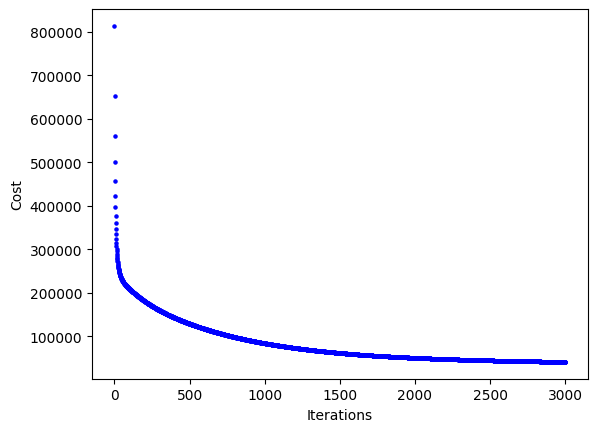

In [37]:
draw_cost_changes(J_hist)

### Predict 

In [38]:
pred = X @ Theta
pred_rescaled = (pred + Ymean) * scale.values / 10
pred_rescaled

array([[3.02160691, 4.19872558, 3.03536773, ..., 3.59076074, 4.02748018,
        4.648242  ],
       [2.73372821, 4.68332497, 3.46232791, ..., 2.88000442, 2.90422427,
        4.02824864],
       [1.8153766 , 1.46583345, 3.16940094, ..., 3.96839554, 4.55610779,
        2.70466079],
       ...,
       [3.67862834, 5.68911779, 5.8060617 , ..., 4.89233946, 4.89698079,
        4.77159237],
       [2.19340989, 3.25172765, 2.65927069, ..., 2.99331024, 2.46697233,
        2.80989844],
       [3.63122247, 4.80040875, 5.02078847, ..., 5.20412457, 5.1431892 ,
        4.96398785]])

### Convert back from pivot to sparse format 

In [39]:
df_results_pivot = pd.DataFrame(pred_rescaled, index=Y.index, columns=Y.columns)

df_results_pivot_temp = pd.DataFrame(df_results_pivot.to_records())
df_results = pd.melt(df_results_pivot_temp,
                     id_vars='movieId',
                     value_vars=list(df_results_pivot_temp.columns[1:]),
                     var_name='userId',
                     value_name='rating_pred')
df_results

,movieId,userId,rating_pred
0,1,1,3.021607
1,2,1,2.733728
2,3,1,1.815377
3,4,1,1.891425
4,5,1,1.614697
...,...,...,...
6083281,161944,671,5.087000
6083282,162376,671,5.059121
6083283,162542,671,4.771592
6083284,162672,671,2.809898


### Round to existing values 

In [40]:
existing_unique_values = np.array(sorted(Df['rating'].unique()))

def round_to_existing(val):
    return existing_unique_values[np.argmin(np.abs(existing_unique_values-val))]

df_results['rating_round'] = df_results['rating_pred'].apply(round_to_existing)
df_results

,movieId,userId,rating_pred,rating_round
0,1,1,3.021607,3.0
1,2,1,2.733728,2.5
2,3,1,1.815377,2.0
3,4,1,1.891425,2.0
4,5,1,1.614697,1.5
...,...,...,...,...
6083281,161944,671,5.087000,5.0
6083282,162376,671,5.059121,5.0
6083283,162542,671,4.771592,5.0
6083284,162672,671,2.809898,3.0


In [41]:
df_results['userId'] = df_results['userId'].astype(int)
df_eval = Df.merge(df_results, on=['userId', 'movieId'])
df_eval

,userId,movieId,rating,rating_pred,rating_round
0,1,31,2.5,2.501333,2.5
1,1,1029,3.0,3.037794,3.0
2,1,1061,3.0,2.921360,3.0
3,1,1129,2.0,2.046553,2.0
4,1,1172,4.0,3.752005,4.0
...,...,...,...,...,...
99999,671,6268,2.5,2.574489,2.5
100000,671,6269,4.0,3.940611,4.0
100001,671,6365,4.0,3.992779,4.0
100002,671,6385,2.5,2.886267,3.0


In [42]:
from sklearn.metrics import r2_score

0.8770390749064889
mean error = 0.25285738887403103, max error = 2.8034443699061136


<Axes: >

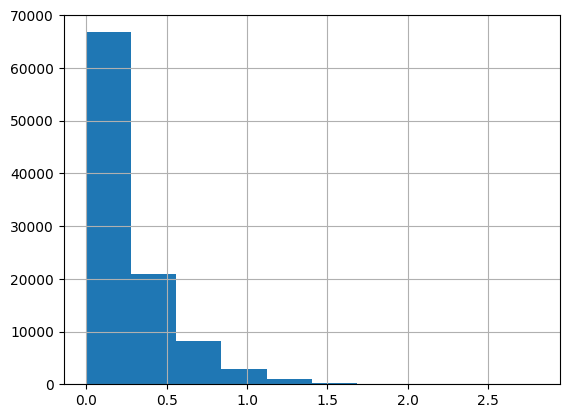

In [43]:
print(r2_score(df_eval['rating'], df_eval['rating_pred']))

df_eval['diff'] = df_eval['rating'] - df_eval['rating_pred']
df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

0.866815031350723
mean error = 0.21638134474621015, max error = 3.0


<Axes: >

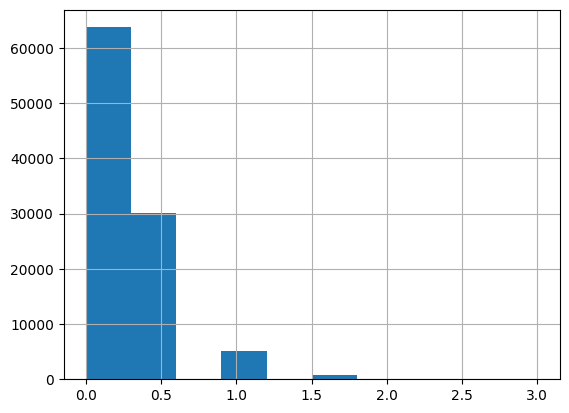

In [44]:
print(r2_score(df_eval['rating'], df_eval['rating_round']))
df_eval['diff'] = df_eval['rating'] - df_eval['rating_round']
df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

## Evaluate cofi on test set 

In [45]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(Df, test_size=1000)
df_train.shape, df_test.shape

((99004, 3), (1000, 3))

C:\Users\38098\AppData\Local\Temp\ipykernel_6168\3295130093.py:2: FutureWarning: The provided callable <function max at 0x000001BFB2B2F240> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  Dataset_target = Dataset.pivot_table(value, index, columns, aggfunc=np.max, dropna=False)


Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 3000
50: 229708.64863309605
100: 206445.9790810072
150: 190731.7841398696
200: 177829.61488034925
250: 166981.8498626361
300: 157546.7841350088
350: 149124.9567986537
400: 141486.52725048907
450: 134485.83309089812
500: 128019.69069548635
550: 122010.37746915752
600: 116399.72212270321
650: 111146.29238855027
700: 106221.91733268481
750: 101607.32788841323
800: 97288.04109688717
850: 93251.30392206431
900: 89484.26707098025
950: 85973.24027778176
1000: 82703.82202870434
1050: 79661.59866979103
1100: 76832.93124342724
1150: 74205.33306381322
1200: 71767.23273758405
1250: 69507.34243925684
1300: 67414.08377586075
1350: 65475.410626349774
1400: 63679.05810533707
1450: 62013.00731360276
1500: 60465.91918659126
1550: 59027.39785755707
1600: 57688.06941074231
1650: 56439.53263871694
1700: 55274.25064134065
1750: 54185.43309170007
1800: 53166.93400655374
1850: 52213.17141969559
1900: 51319.06586687147
1950: 50479.991

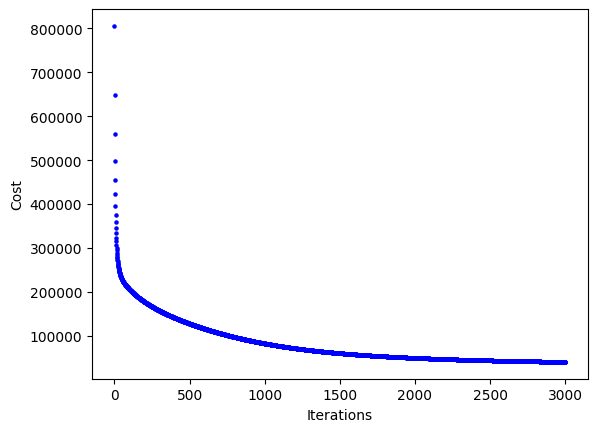

In [46]:
df_target = Convert_to_Matrix(df_train, 'rating','movieId', 'userId')

Y, R = get_Y_and_R(df_target)

Y_scaled,scale = get_Y_scaled(Y)

Ymean, Ynorm = normalize_Y(Y_scaled.values, R.values, Y_scaled.shape[0])

X, Theta, J_hist = fit(Ynorm, R.values, num_features=20, alpha=0.0005, lambd=1, max_iter=3000,
                       eps=.01, step=50, verbose=1)
draw_cost_changes(J_hist)

In [47]:
pred = X @ Theta
pred_rescaled = (pred + Ymean) * scale.values / 10

df_results_pivot = pd.DataFrame(pred_rescaled, index=Y.index, columns=Y.columns)
df_results_pivot_temp = pd.DataFrame(df_results_pivot.to_records())
df_results = pd.melt(df_results_pivot_temp,
                     id_vars='movieId',
                     value_vars=list(df_results_pivot_temp.columns[1:]),
                     var_name='userId',
                     value_name='rating_pred')
df_results

,movieId,userId,rating_pred
0,1,1,2.504196
1,2,1,3.139225
2,3,1,4.349239
3,4,1,2.545443
4,5,1,1.936236
...,...,...,...
6063151,161944,671,4.888925
6063152,162376,671,4.495443
6063153,162542,671,5.145518
6063154,162672,671,3.082807


### Evaluate on train set 

In [48]:
df_results['userId'] = df_results['userId'].astype(int)
df_eval = df_train.merge(df_results, on=['userId', 'movieId'])

r2_score= 0.8799897775066371
mean error = 0.24993828258579975, max error = 3.111551601420147


<Axes: >

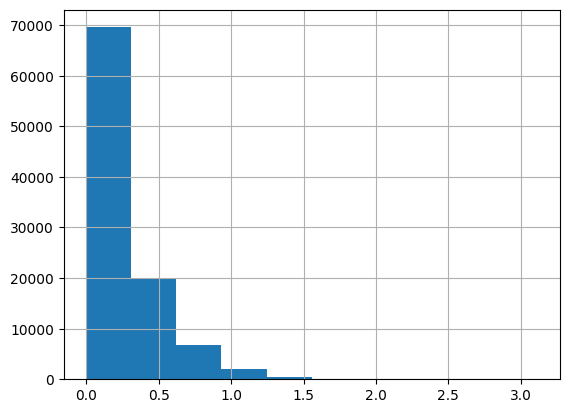

In [49]:
print('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred']))
df_eval['diff'] = df_eval['rating'] - df_eval['rating_pred']

df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

### Evaluate on test set 

In [50]:

df_results['userId'] = df_results['userId'].astype(int)
df_eval = df_test.merge(df_results, on=['userId', 'movieId'])
df_eval

,userId,movieId,rating,rating_pred
0,430,3,1.5,4.409043
1,311,4661,4.0,4.345025
2,554,1193,5.0,4.780947
3,516,1092,3.0,3.218247
4,130,288,1.0,4.409330
...,...,...,...,...
965,382,2059,5.0,2.376576
966,243,1590,3.5,5.231088
967,102,802,3.0,3.305079
968,528,608,4.0,4.315986


r2_score= -0.12113168270670593
mean error = 0.8365233491877215, max error = 4.493722573936896


<Axes: >

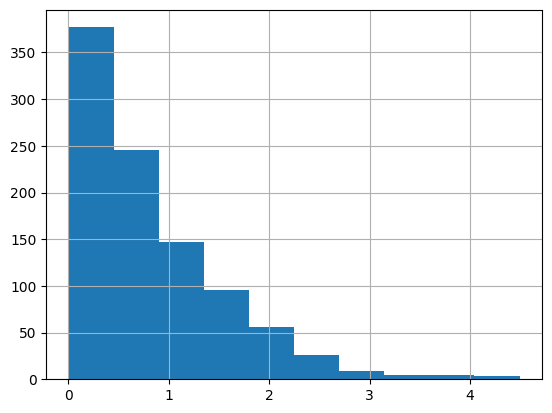

In [51]:
print('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred']))
df_eval['diff'] = df_eval['rating'] - df_eval['rating_pred']

df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

In [52]:
print('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred']))

r2_score= -0.12113168270670593


r2_score= -0.04053220761016485
mean error = 0.7860824742268041, max error = 4.5


<Axes: >

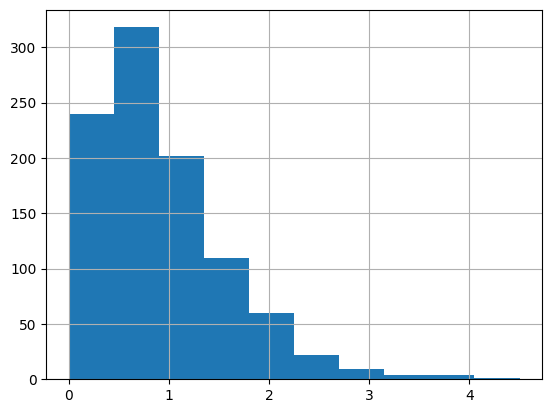

In [53]:
df_results['rating_round'] = df_results['rating_pred'].apply(round_to_existing)
df_eval = df_test.merge(df_results, on=['userId', 'movieId'])
print('r2_score=', r2_score(df_eval['rating'], df_eval['rating_round']))
df_eval['diff'] = df_eval['rating'] - df_eval['rating_round']

df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()